---
title: "Protein Folding with Genetic Algorithms"
subtitle: "BMES 678: Programming Assignment"
author: "Tony Kabilan Okeke"
format: PrettyPDF-pdf
---

**Warning:** This assignment is an oversimplification of the forces and interactions involved in protein folding. Model protein folding as a minimization problem. While a state of the art implementation would use a more complete force-field (where bonded and non-bonded interactions) are implemented, we use here possibly inaccurate simplifications to calculate the fitness a folded protein.

In this assignment, you are going to "fold" a protein using Genetic Algorithms. The genetic algorithm will be used to find the coordinates of amino acids that result in the best "fitness".

### Changes made to `rnafoldga_demo` files

List below, the function(s) that you have modified and what changes you have made.

- I created python implementations for the functions in `rnafoldga_demo`
- For the genetic algorithm, i use the `deap` library with parameters based on MATLAB's documentation.

The implementations are available in the `ptnfold.py` file.

In [1]:
%load_ext autoreload
%autoreload 2

import ptnfold

In [2]:
from scipy.spatial.distance import pdist, squareform
from deap import base, creator, tools, algorithms
from multiprocessing import Pool

import pandas as pd
import numpy as np

import random
import json

np.random.seed(42)
random.seed(42)

### Visualize Protein 

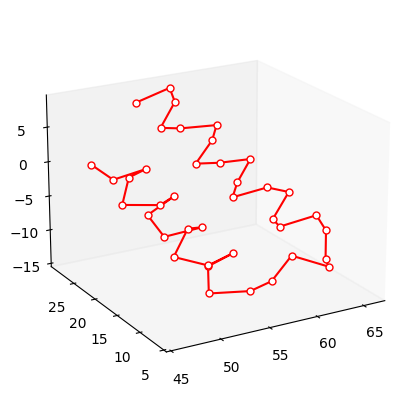

In [3]:
#| fig-align: center
#| fig-cap: "Protein Folding for 1gzmA48-86"

# download file
url = "https://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course:sim2:moleculardynamics:hwptnfoldga:1gzmA48-86.tab"
filename = "1gzmA48-86.tab"
ptnfold.downloadurl(url, filename)

# load file
ptn = pd.read_csv(filename, sep="\t")
ptn.head()

# extract data
seq = ptn['base'].str.upper().values
locs = ptn[['x', 'y', 'z']].values

# compute distance matrix
dist = squareform(pdist(locs))

# plot RNA
ptnfold.rna_plot(locs, pairs=None)

### Detect Hydrogen Bonds

Write a function `ptn_gethydrogenbondedpairs()` to get the hydrogen bonded pairs of amino acids. Your function should **return a 2-column matrix of the indicies of the residuces that have hydrogen bonds between them.** The H-donor should be listed in the first column and the H-acceptor in the second column. **Do not sort the pairs matrix, so that the pairs appear in the order of their distances.**

Hydrogen bonds should be determined using the following rules (these rules may not reflect the statistics or constraints of real proteins):

- Amino acids (aka "residues") that are between 3-15 Angstroms are considered hydrogen-bonded (assuming they satisfy additional rules below).

- There needs to be at least 1 residue between hydrogen-bonding (i.e,. amino acids that are consecutive in the sequence cannot form a hydrogen bond.

- Each residue can form H-bond with at most two other different residues. (In reality, these assumptions are not accurate; an amino acid in reality can form additional H-bonds via their side-chains, which we'll ignore here).

- Each residue can act as a H-donor at most once.

- Each residue can act as a H-acceptor at most once.

- If a residue A acts as a H-donor to a residue B; residue A cannot act as a H-acceptor to the residue B.

- A H-bond is formed between an available H-donor and available H-acceptor.

- Proline cannot act as a H-donor, but can act as an H-acceptor.

- If multiple partners satisfy these requirements, use the pair with the smallest distance as H-bonding partners. If there are multiple pairs with the smallest such distance, use the pair that would come first when sortrows were applied to the list of these pairs.

- Follow a greedy matching strategy to pair up the closest eligible/available partners at each step. Repeat until no eligible pairs remain.

Your function should use the distance matrix if one is given as input or calculate it if it is not given.

> **See `ptnfold.py` for the implementation of `ptn_gethydrogenbondedpairs()`**

shape: (37, 2)
[[33 35 39 12 13  8 24 31 32 30 28  4 29 10 37 38 26 17 27 36]
 [ 8 32 36  9 10 11 27 28 29 33 25  1 31  7 34 35 23 14 30 38]]


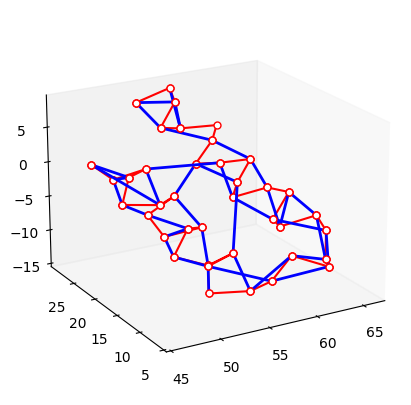

In [4]:
#| fig-align: center
#| fig-cap: "Protein Folding with Hydrogen Bonds for 1gzmA48-86"

pairs = ptnfold.ptn_gethydrogenbondedpairs(seq, locs)
print("shape:", pairs.shape)
print(pairs[0:20, :].T)

ptnfold.rna_plot(locs, pairs=pairs)

### Calculate Fitness

Write a function `ptn_fitness()` that returns a fitness score based on the following criteria. Return the total fitness score as well as information about the breakdown of the fitness scores in the following categories. For violations, the information should contain the number of violations.

- The more hydrogen bonds a protein has the better the fittness.

- Residues that are consecutive (in the primary sequence) should be between 3.7-3.9 Angstroms apart.
  - For each residue pair that do not satisfy this, use the difference from this ideal distance range as a penalty for fitness.
  - If you penalize for residue pair `<i,j>`, do not penalize for `<j,i>`. 
  - In the information structure, use `numseqviolations` as the count of these violations and `seqviolations` as the fitness penalty resulting from them.

- non-consecutive residues should be further than 3 Angstroms.
  - For each residue pair that do not satisfy this, use the difference from this minimal distance as a penalty for fitness.
  - If you penalize for residue pair `<i,j>`, do not penalize for pair `<i,j>`.
  - In the information structure, use `numnonseqviolations` as the count of these violations and `nonseqviolations` as the fitness penalty resulting from them.

Your function should use the distance matrix if one is given as input or calculate it if it is not given. Your function should work with locations formatted as a 3-column matrix as well as given as a row-matrix of concatenated `<x,y,z>` coordinates.


In [5]:
fitness, info = ptnfold.ptn_fitness(seq, locs, dist)
print(f"Fitness: {fitness}")
print(f"Info: {json.dumps(info, indent=4)}")

Fitness: 37.0
Info: {
    "totalhbonds": 37,
    "numseqviolations": 0,
    "numnonseqviolations": 0,
    "seqviolations": 0,
    "nonseqviolations": 0.0
}


### Run Genetic Algorithm to find the best structure

In [7]:
# Define the crossover function
def rnafoldga_crossover(ind1, ind2):
    size = len(ind1)
    at = random.randint(1, size // 3 - 1) * 3
    ind1[at:], ind2[at:] = ind2[at:], ind1[at:]
    return ind1, ind2

# Setup DEAP framework for genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define the individual and population
def create_individual():
    return np.random.uniform(low=-10.0, high=10.0, size=num_vars)

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval_fitness(individual):
    fitness, _ = ptnfold.ptn_fitness(seq, individual.reshape(-1, 3))
    return fitness,

toolbox.register("evaluate", eval_fitness)
toolbox.register("mate", rnafoldga_crossover)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parallel processing setup
pool = Pool()
toolbox.register("map", pool.map)

# Genetic Algorithm parameters
num_vars = len(seq) * 3
population_size = 300
crossover_prob = 0.7
mutation_prob = 0.2
num_generations = 40

# Create initial population
pop = toolbox.population(n=population_size)

# Run the genetic algorithm
result, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_prob, mutpb=mutation_prob,
                                  ngen=num_generations, verbose=True)

# Close the pool
pool.close()

# Best solution
best = tools.selBest(pop, 1)[0]
best_locs = np.asarray(best.reshape(-1, 3))

gen	nevals
0  	300   
1  	205   
2  	215   
3  	218   
4  	224   
5  	235   
6  	218   
7  	224   
8  	222   
9  	230   
10 	212   
11 	239   
12 	222   
13 	227   
14 	223   
15 	230   
16 	214   
17 	234   
18 	228   
19 	210   
20 	221   
21 	234   
22 	202   
23 	240   
24 	236   
25 	218   
26 	245   
27 	221   
28 	218   
29 	224   
30 	229   
31 	229   
32 	207   
33 	226   
34 	233   
35 	220   
36 	242   
37 	226   
38 	235   
39 	237   
40 	223   


Fitness: -75.0803246023453
Info: {
    "totalhbonds": 36,
    "numseqviolations": 35,
    "numnonseqviolations": 7,
    "seqviolations": 106.71325581789488,
    "nonseqviolations": 4.367068784450419
}


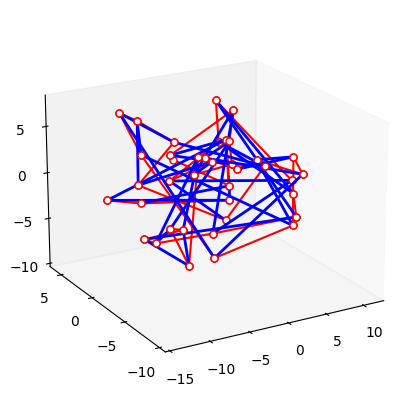

In [8]:
#| fig-align: center
#| fig-cap: "Protein Folding with Genetic Algorithms for 1gzmA48-86"

ptnfold.rna_plot(best_locs, pairs=pairs)

fitness, info = ptnfold.ptn_fitness(seq, best_locs)
print(f"Fitness: {fitness}")
print(f"Info: {json.dumps(info, indent=4)}")